In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import timm
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.io import read_image
from torchvision.transforms import v2

import pandas as pd
cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
data_path = '/kaggle/input/smai-24-age-prediction/content/faces_dataset'

In [4]:
# HYPS
batch_size = 8
LR = 1e-3

In [5]:
class FaceDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1].astype(np.float32)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
train_data_csv = '/kaggle/input/smai-24-age-prediction/content/faces_dataset/train.csv'
train_data_dir = '/kaggle/input/smai-24-age-prediction/content/faces_dataset/train'
tsfm = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
face_data = FaceDataset(train_data_csv, train_data_dir, transform=tsfm)

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


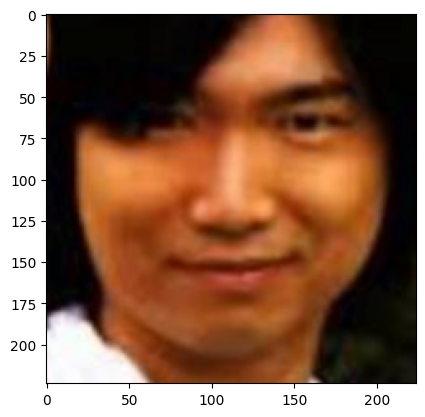

In [8]:
inp, cls = face_data[0]
out = torchvision.utils.make_grid(inp)
imshow(out)

In [9]:
train_face_data, val_face_data = torch.utils.data.random_split(face_data, lengths=[0.9, 0.1])

In [10]:
train_face_dataloader = DataLoader(train_face_data, batch_size=batch_size, shuffle=True, num_workers=1)
val_face_dataloader = DataLoader(val_face_data, batch_size=batch_size, shuffle=False, num_workers=1)

In [11]:
datasets = {'train':train_face_data, 'val':val_face_data}
dataloaders = {'train':train_face_dataloader, 'val':val_face_dataloader}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}

In [12]:
dataset_sizes

{'train': 19206, 'val': 2134}

In [13]:
for inputs, labels in dataloaders['train']:
    print(labels.reshape(-1, 1).shape)
    break

torch.Size([8, 1])


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    labels = labels.reshape(-1, 1)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_loss > best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Loss: {best_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {outputs[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
model_timm = timm.create_model('tf_efficientnet_b4.ns_jft_in1k', pretrained=True)
model_timm

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [17]:
num_ftrs = model_timm.classifier.in_features
model_timm.classifier = nn.Linear(num_ftrs, 1)
model_timm = model_timm.to(device)
print(model_timm)
criterion = nn.L1Loss()
optimizer_ft = optim.Adam(model_timm.parameters(), lr=LR)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          24, ep

In [19]:
model_timm = train_model(model_timm, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=35)

Epoch 0/34
----------
train Loss: 7.9262
val Loss: 6.3510

Epoch 1/34
----------
train Loss: 6.1544
val Loss: 6.0948

Epoch 2/34
----------
train Loss: 5.7298
val Loss: 5.9481

Epoch 3/34
----------
train Loss: 5.3476
val Loss: 5.7537

Epoch 4/34
----------
train Loss: 5.1776
val Loss: 5.3155

Epoch 5/34
----------
train Loss: 4.9172
val Loss: 5.4756

Epoch 6/34
----------
train Loss: 4.8126
val Loss: 5.2050

Epoch 7/34
----------
train Loss: 4.0541
val Loss: 4.8252

Epoch 8/34
----------
train Loss: 3.8119
val Loss: 4.8310

Epoch 9/34
----------
train Loss: 3.6444
val Loss: 4.8104

Epoch 10/34
----------
train Loss: 3.5454
val Loss: 4.8655

Epoch 11/34
----------
train Loss: 3.4263
val Loss: 4.8888

Epoch 12/34
----------
train Loss: 3.3303
val Loss: 4.8153

Epoch 13/34
----------
train Loss: 3.2292
val Loss: 4.7897

Epoch 14/34
----------
train Loss: 3.0629
val Loss: 4.8429

Epoch 15/34
----------
train Loss: 3.0422
val Loss: 4.8095

Epoch 16/34
----------
train Loss: 3.0402
val Loss

In [22]:
# model_ft = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.classifier[1].in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# # model_ft.fc = nn.Linear(num_ftrs, 1)
# model_ft.classifier[1] = nn.Linear(num_ftrs, 1)
# print(model_ft)
# model_ft = model_ft.to(device)

# criterion = nn.MSELoss()

# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [88]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=15)

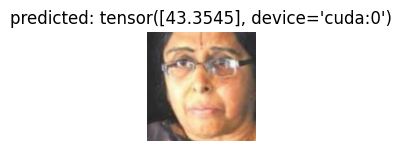

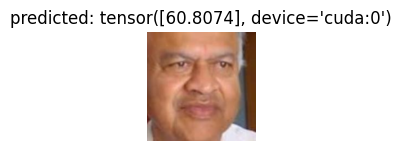

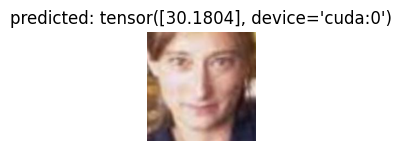

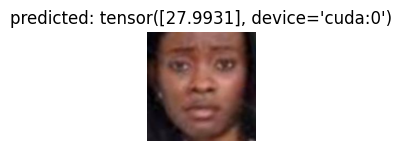

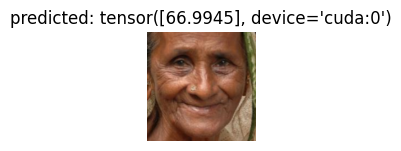

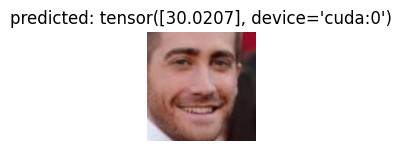

In [20]:
visualize_model(model_timm)

In [21]:
test_data_dir = '/kaggle/input/smai-24-age-prediction/content/faces_dataset/test'
submission_data_csv = '/kaggle/input/smai-24-age-prediction/content/faces_dataset/submission.csv'

In [22]:
test_face_data = FaceDataset(submission_data_csv, test_data_dir, transform=tsfm)
test_face_dataloader = DataLoader(test_face_data, batch_size=1, shuffle=False)

In [23]:
def inference(model):
    model.eval()
    res = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_face_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            res.append(outputs.item())
    return res


In [24]:
res = inference(model_timm)

In [25]:
sub_csv = pd.read_csv(submission_data_csv)
sub_csv['age'] = res

In [26]:
sub_csv.to_csv('submission.csv',index=False)